In [11]:
import json
import os
import pprint

import numpy as np
import torch
import torch.utils.data as data
import sys
import time
import copy
import pickle as pkl

from datetime import datetime

import geopandas as gpd
import pandas as pd

import collections.abc
import re

from torch.nn import functional as F

helper_path = '/kaggle/input/utae-pap-helper-files/utae-paps-main'
sys.path.insert(0,helper_path)


from src.panoptic.paps_loss import PaPsLoss
from src.utils import pad_collate
from src.panoptic.metrics import PanopticMeter



### Dataset class renewed using updated packages

In [12]:
class PASTIS_Dataset(data.Dataset):
    def __init__(
        self,
        folder,
        norm=True,
        target="semantic",
        cache=False,
        mem16=False,
        folds=None,
        reference_date="2018-09-01",
        class_mapping=None,
        mono_date=None,
        sats=["S2"],
    ):
        """
        Pytorch Dataset class to load samples from the PASTIS dataset, for semantic and
        panoptic segmentation.

        The Dataset yields ((data, dates), target) tuples, where:
            - data contains the image time series
            - dates contains the date sequence of the observations expressed in number
              of days since a reference date
            - target is the semantic or instance target

        Args:
            folder (str): Path to the dataset
            norm (bool): If true, images are standardised using pre-computed
                channel-wise means and standard deviations.
            reference_date (str, Format : 'YYYY-MM-DD'): Defines the reference date
                based on which all observation dates are expressed. Along with the image
                time series and the target tensor, this dataloader yields the sequence
                of observation dates (in terms of number of days since the reference
                date). This sequence of dates is used for instance for the positional
                encoding in attention based approaches.
            target (str): 'semantic' or 'instance'. Defines which type of target is
                returned by the dataloader.
                * If 'semantic' the target tensor is a tensor containing the class of
                  each pixel.
                * If 'instance' the target tensor is the concatenation of several
                  signals, necessary to train the Parcel-as-Points module:
                    - the centerness heatmap,
                    - the instance ids,
                    - the voronoi partitioning of the patch with regards to the parcels'
                      centers,
                    - the (height, width) size of each parcel
                    - the semantic label of each parcel
                    - the semantic label of each pixel
            cache (bool): If True, the loaded samples stay in RAM, default False.
            mem16 (bool): Additional argument for cache. If True, the image time
                series tensors are stored in half precision in RAM for efficiency.
                They are cast back to float32 when returned by __getitem__.
            folds (list, optional): List of ints specifying which of the 5 official
                folds to load. By default (when None is specified) all folds are loaded.
            class_mapping (dict, optional): Dictionary to define a mapping between the
                default 18 class nomenclature and another class grouping, optional.
            mono_date (int or str, optional): If provided only one date of the
                available time series is loaded. If argument is an int it defines the
                position of the date that is loaded. If it is a string, it should be
                in format 'YYYY-MM-DD' and the closest available date will be selected.
            sats (list): defines the satellites to use. If you are using PASTIS-R, you have access to
                Sentinel-2 imagery and Sentinel-1 observations in Ascending and Descending orbits,
                respectively S2, S1A, and S1D.
                For example use sats=['S2', 'S1A'] for Sentinel-2 + Sentinel-1 ascending time series,
                or sats=['S2', 'S1A','S1D'] to retrieve all time series.
                If you are using PASTIS, only  S2 observations are available.
        """
        super(PASTIS_Dataset, self).__init__()
        self.folder = folder
        self.norm = norm
        self.reference_date = datetime(*map(int, reference_date.split("-")))
        self.cache = cache
        self.mem16 = mem16
        self.mono_date = None
        if mono_date is not None:
            self.mono_date = (
                datetime(*map(int, mono_date.split("-")))
                if "-" in mono_date
                else int(mono_date)
            )
        self.memory = {}
        self.memory_dates = {}
        self.class_mapping = (
            np.vectorize(lambda x: class_mapping[x])
            if class_mapping is not None
            else class_mapping
        )
        self.target = target
        self.sats = sats

        # Get metadata
        print("Reading patch metadata . . .")
        self.meta_patch = gpd.read_file(os.path.join(folder, "metadata.geojson"))
        self.meta_patch.index = self.meta_patch["ID_PATCH"].astype(int)
        self.meta_patch.sort_index(inplace=True)

        self.date_tables = {s: None for s in sats}
        self.date_range = np.array(range(-200, 600))
        for s in sats:
            dates = self.meta_patch["dates-{}".format(s)]
            date_table = pd.DataFrame(
                index=self.meta_patch.index, columns=self.date_range, dtype=int
            )
            for pid, date_seq in dates.items():
                d = pd.DataFrame().from_dict(date_seq, orient="index")
                d = d[0].apply(
                    lambda x: (
                        datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]))
                        - self.reference_date
                    ).days
                )
                date_table.loc[pid, d.values] = 1
            date_table = date_table.fillna(0)
            self.date_tables[s] = {
                index: np.array(list(d.values()))
                for index, d in date_table.to_dict(orient="index").items()
            }

        print("Done.")

        # Select Fold samples
        if folds is not None:
            self.meta_patch = pd.concat(
                [self.meta_patch[self.meta_patch["Fold"] == f] for f in folds]
            )

        self.len = self.meta_patch.shape[0]
        self.id_patches = self.meta_patch.index

        # Get normalisation values
        if norm:
            self.norm = {}
            for s in self.sats:
                with open(
                    os.path.join(folder, "NORM_{}_patch.json".format(s)), "r"
                ) as file:
                    normvals = json.loads(file.read())
                selected_folds = folds if folds is not None else range(1, 6)
                means = [normvals["Fold_{}".format(f)]["mean"] for f in selected_folds]
                stds = [normvals["Fold_{}".format(f)]["std"] for f in selected_folds]
                self.norm[s] = np.stack(means).mean(axis=0), np.stack(stds).mean(axis=0)
                self.norm[s] = (
                    torch.from_numpy(self.norm[s][0]).float(),
                    torch.from_numpy(self.norm[s][1]).float(),
                )
        else:
            self.norm = None
        print("Dataset ready.")

    def __len__(self):
        return self.len

    def get_dates(self, id_patch, sat):
        return self.date_range[np.where(self.date_tables[sat][id_patch] == 1)[0]]

    def __getitem__(self, item):
        id_patch = self.id_patches[item]

        # Retrieve and prepare satellite data
        if not self.cache or item not in self.memory.keys():
            data = {
                satellite: np.load(
                    os.path.join(
                        self.folder,
                        "DATA_{}".format(satellite),
                        "{}_{}.npy".format(satellite, id_patch),
                    )
                ).astype(np.float32)
                for satellite in self.sats
            }  # T x C x H x W arrays
            data = {s: torch.from_numpy(a) for s, a in data.items()}

            if self.norm is not None:
                data = {
                    s: (d - self.norm[s][0][None, :, None, None])
                    / self.norm[s][1][None, :, None, None]
                    for s, d in data.items()
                }

            if self.target == "semantic":
                target = np.load(
                    os.path.join(
                        self.folder, "ANNOTATIONS", "TARGET_{}.npy".format(id_patch)
                    )
                )
                target = torch.from_numpy(target[0].astype(int))

                if self.class_mapping is not None:
                    target = self.class_mapping(target)

            elif self.target == "instance":
                heatmap = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "HEATMAP_{}.npy".format(id_patch),
                    )
                )

                instance_ids = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "INSTANCES_{}.npy".format(id_patch),
                    )
                )
                pixel_to_object_mapping = np.load(
                    os.path.join(
                        self.folder,
                        "INSTANCE_ANNOTATIONS",
                        "ZONES_{}.npy".format(id_patch),
                    )
                )

                pixel_semantic_annotation = np.load(
                    os.path.join(
                        self.folder, "ANNOTATIONS", "TARGET_{}.npy".format(id_patch)
                    )
                )

                if self.class_mapping is not None:
                    pixel_semantic_annotation = self.class_mapping(
                        pixel_semantic_annotation[0]
                    )
                else:
                    pixel_semantic_annotation = pixel_semantic_annotation[0]

                size = np.zeros((*instance_ids.shape, 2))
                object_semantic_annotation = np.zeros(instance_ids.shape)
                for instance_id in np.unique(instance_ids):
                    if instance_id != 0:
                        h = (instance_ids == instance_id).any(axis=-1).sum()
                        w = (instance_ids == instance_id).any(axis=-2).sum()
                        size[pixel_to_object_mapping == instance_id] = (h, w)
                        object_semantic_annotation[
                            pixel_to_object_mapping == instance_id
                        ] = pixel_semantic_annotation[instance_ids == instance_id][0]

                target = torch.from_numpy(
                    np.concatenate(
                        [
                            heatmap[:, :, None],  # 0
                            instance_ids[:, :, None],  # 1
                            pixel_to_object_mapping[:, :, None],  # 2
                            size,  # 3-4
                            object_semantic_annotation[:, :, None],  # 5
                            pixel_semantic_annotation[:, :, None],  # 6
                        ],
                        axis=-1,
                    )
                ).float()

            if self.cache:
                if self.mem16:
                    self.memory[item] = [{k: v.half() for k, v in data.items()}, target]
                else:
                    self.memory[item] = [data, target]

        else:
            data, target = self.memory[item]
            if self.mem16:
                data = {k: v.float() for k, v in data.items()}

        # Retrieve date sequences
        if not self.cache or id_patch not in self.memory_dates.keys():
            dates = {
                s: torch.from_numpy(self.get_dates(id_patch, s)) for s in self.sats
            }
            if self.cache:
                self.memory_dates[id_patch] = dates
        else:
            dates = self.memory_dates[id_patch]

        if self.mono_date is not None:
            if isinstance(self.mono_date, int):
                data = {s: data[s][self.mono_date].unsqueeze(0) for s in self.sats}
                dates = {s: dates[s][self.mono_date] for s in self.sats}
            else:
                mono_delta = (self.mono_date - self.reference_date).days
                mono_date = {
                    s: int((dates[s] - mono_delta).abs().argmin()) for s in self.sats
                }
                data = {s: data[s][mono_date[s]].unsqueeze(0) for s in self.sats}
                dates = {s: dates[s][mono_date[s]] for s in self.sats}

        if self.mem16:
            return ({k: v.float() for k, v in data.items()}, dates), target
        else:
            return (data, dates), target

### Model definition

In [13]:
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat(
            [input_tensor, h_cur], dim=1
        )  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, device):
        return (
            Variable(
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width)
            ).to(device),
            Variable(
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width)
            ).to(device),
        )


class ConvLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        input_dim,
        hidden_dim,
        kernel_size,
        num_layers=1,
        batch_first=True,
        bias=True,
        return_all_layers=False,
    ):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_size=(self.height, self.width),
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None, pad_mask=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        pad_maks (b , t)
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(
                batch_size=input_tensor.size(0), device=input_tensor.device
            )

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            if pad_mask is not None:
                last_positions = (~pad_mask).sum(dim=1) - 1
                layer_output = layer_output[:, last_positions, :, :, :]

            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, device):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, device))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (
            isinstance(kernel_size, tuple)
            or (
                isinstance(kernel_size, list)
                and all([isinstance(elem, tuple) for elem in kernel_size])
            )
        ):
            raise ValueError("`kernel_size` must be tuple or list of tuples")

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvLSTM_Seg(nn.Module):
    def __init__(
        self, num_classes, input_size, input_dim, hidden_dim, kernel_size, pad_value=0
    ):
        super(ConvLSTM_Seg, self).__init__()
        self.convlstm_encoder = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.classification_layer = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=num_classes,
            kernel_size=kernel_size,
            padding=1,
        )
        self.pad_value = pad_value

    def forward(self, input, batch_positions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        pad_mask = pad_mask if pad_mask.any() else None
        _, states = self.convlstm_encoder(input, pad_mask=pad_mask)
        out = states[0][1]  # take last cell state as embedding
        out = self.classification_layer(out)

        return out


class BConvLSTM_Seg(nn.Module):
    def __init__(
        self, num_classes, input_size, input_dim, hidden_dim, kernel_size, pad_value=0
    ):
        super(BConvLSTM_Seg, self).__init__()
        self.convlstm_forward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.convlstm_backward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.classification_layer = nn.Conv2d(
            in_channels=2 * hidden_dim,
            out_channels=num_classes,
            kernel_size=kernel_size,
            padding=1,
        )
        self.pad_value = pad_value

    def forward(self, input, batch_posistions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        pad_mask = pad_mask if pad_mask.any() else None

        # FORWARD
        _, forward_states = self.convlstm_forward(input, pad_mask=pad_mask)
        out = forward_states[0][1]  # take last cell state as embedding

        # BACKWARD
        x_reverse = torch.flip(input, dims=[1])
        if pad_mask is not None:
            pmr = torch.flip(pad_mask.float(), dims=[1]).bool()
            x_reverse = torch.masked_fill(x_reverse, pmr[:, :, None, None, None], 0)
            # Fill leading padded positions with 0s
        _, backward_states = self.convlstm_backward(x_reverse)

        out = torch.cat([out, backward_states[0][1]], dim=1)
        out = self.classification_layer(out)
        return out


class BConvLSTM(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size):
        super(BConvLSTM, self).__init__()
        self.convlstm_forward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.convlstm_backward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )

    def forward(self, input, pad_mask=None):
        # FORWARD
        _, forward_states = self.convlstm_forward(input, pad_mask=pad_mask)
        out = forward_states[0][1]  # take last cell state as embedding

        # BACKWARD
        x_reverse = torch.flip(input, dims=[1])
        if pad_mask is not None:
            pmr = torch.flip(pad_mask.float(), dims=[1]).bool()
            x_reverse = torch.masked_fill(x_reverse, pmr[:, :, None, None, None], 0)
            # Fill leading padded positions with 0s
        _, backward_states = self.convlstm_backward(x_reverse)

        out = torch.cat([out, backward_states[0][1]], dim=1)
        return out

In [14]:
class PositionalEncoder(nn.Module):
    def __init__(self, d, T=1000, repeat=None, offset=0):
        super(PositionalEncoder, self).__init__()
        self.d = d
        self.T = T
        self.repeat = repeat
        self.denom = torch.pow(
            T, 2 * (torch.arange(offset, offset + d).float() // 2) / d
        )
        self.updated_location = False

    def forward(self, batch_positions):
        if not self.updated_location:
            self.denom = self.denom.to(batch_positions.device)
            self.updated_location = True
        sinusoid_table = (
            batch_positions[:, :, None] / self.denom[None, None, :]
        )  # B x T x C
        sinusoid_table[:, :, 0::2] = torch.sin(sinusoid_table[:, :, 0::2])  # dim 2i
        sinusoid_table[:, :, 1::2] = torch.cos(sinusoid_table[:, :, 1::2])  # dim 2i+1

        if self.repeat is not None:
            sinusoid_table = torch.cat(
                [sinusoid_table for _ in range(self.repeat)], dim=-1
            )

        return sinusoid_table

In [15]:
class LTAE2d(nn.Module):
    def __init__(
        self,
        in_channels=128,
        n_head=16,
        d_k=4,
        mlp=[256, 128],
        dropout=0.2,
        d_model=256,
        T=1000,
        return_att=False,
        positional_encoding=True,
    ):
        """
        Lightweight Temporal Attention Encoder (L-TAE) for image time series.
        Attention-based sequence encoding that maps a sequence of images to a single feature map.
        A shared L-TAE is applied to all pixel positions of the image sequence.
        Args:
            in_channels (int): Number of channels of the input embeddings.
            n_head (int): Number of attention heads.
            d_k (int): Dimension of the key and query vectors.
            mlp (List[int]): Widths of the layers of the MLP that processes the concatenated outputs of the attention heads.
            dropout (float): dropout
            d_model (int, optional): If specified, the input tensors will first processed by a fully connected layer
                to project them into a feature space of dimension d_model.
            T (int): Period to use for the positional encoding.
            return_att (bool): If true, the module returns the attention masks along with the embeddings (default False)
            positional_encoding (bool): If False, no positional encoding is used (default True).
        """
        super(LTAE2d, self).__init__()
        self.in_channels = in_channels
        self.mlp = copy.deepcopy(mlp)
        self.return_att = return_att
        self.n_head = n_head

        if d_model is not None:
            self.d_model = d_model
            self.inconv = nn.Conv1d(in_channels, d_model, 1)
        else:
            self.d_model = in_channels
            self.inconv = None
        assert self.mlp[0] == self.d_model

        if positional_encoding:
            self.positional_encoder = PositionalEncoder(
                self.d_model // n_head, T=T, repeat=n_head
            )
        else:
            self.positional_encoder = None

        self.attention_heads = MultiHeadAttention(
            n_head=n_head, d_k=d_k, d_in=self.d_model
        )
        self.in_norm = nn.GroupNorm(
            num_groups=n_head,
            num_channels=self.in_channels,
        )
        self.out_norm = nn.GroupNorm(
            num_groups=n_head,
            num_channels=mlp[-1],
        )

        layers = []
        for i in range(len(self.mlp) - 1):
            layers.extend(
                [
                    nn.Linear(self.mlp[i], self.mlp[i + 1]),
                    nn.BatchNorm1d(self.mlp[i + 1]),
                    nn.ReLU(),
                ]
            )

        self.mlp = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, batch_positions=None, pad_mask=None, return_comp=False):
        sz_b, seq_len, d, h, w = x.shape
        if pad_mask is not None:
            pad_mask = (
                pad_mask.unsqueeze(-1)
                .repeat((1, 1, h))
                .unsqueeze(-1)
                .repeat((1, 1, 1, w))
            )  # BxTxHxW
            pad_mask = (
                pad_mask.permute(0, 2, 3, 1).contiguous().view(sz_b * h * w, seq_len)
            )

        out = x.permute(0, 3, 4, 1, 2).contiguous().view(sz_b * h * w, seq_len, d)
        out = self.in_norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if self.inconv is not None:
            out = self.inconv(out.permute(0, 2, 1)).permute(0, 2, 1)

        if self.positional_encoder is not None:
            bp = (
                batch_positions['S2'].unsqueeze(-1)
                .repeat((1, 1, h))
                .unsqueeze(-1)
                .repeat((1, 1, 1, w))
            )  # BxTxHxW
            bp = bp.permute(0, 2, 3, 1).contiguous().view(sz_b * h * w, seq_len)
            out = out + self.positional_encoder(bp)

        out, attn = self.attention_heads(out, pad_mask=pad_mask)

        out = (
            out.permute(1, 0, 2).contiguous().view(sz_b * h * w, -1)
        )  # Concatenate heads
        out = self.dropout(self.mlp(out))
        out = self.out_norm(out) if self.out_norm is not None else out
        out = out.view(sz_b, h, w, -1).permute(0, 3, 1, 2)

        attn = attn.view(self.n_head, sz_b, h, w, seq_len).permute(
            0, 1, 4, 2, 3
        )  # head x b x t x h x w

        if self.return_att:
            return out, attn
        else:
            return out


class MultiHeadAttention(nn.Module):
    """Multi-Head Attention module
    Modified from github.com/jadore801120/attention-is-all-you-need-pytorch
    """

    def __init__(self, n_head, d_k, d_in):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_in = d_in

        self.Q = nn.Parameter(torch.zeros((n_head, d_k))).requires_grad_(True)
        nn.init.normal_(self.Q, mean=0, std=np.sqrt(2.0 / (d_k)))

        self.fc1_k = nn.Linear(d_in, n_head * d_k)
        nn.init.normal_(self.fc1_k.weight, mean=0, std=np.sqrt(2.0 / (d_k)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))

    def forward(self, v, pad_mask=None, return_comp=False):
        d_k, d_in, n_head = self.d_k, self.d_in, self.n_head
        sz_b, seq_len, _ = v.size()

        q = torch.stack([self.Q for _ in range(sz_b)], dim=1).view(
            -1, d_k
        )  # (n*b) x d_k

        k = self.fc1_k(v).view(sz_b, seq_len, n_head, d_k)
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, seq_len, d_k)  # (n*b) x lk x dk

        if pad_mask is not None:
            pad_mask = pad_mask.repeat(
                (n_head, 1)
            )  # replicate pad_mask for each head (nxb) x lk

        v = torch.stack(v.split(v.shape[-1] // n_head, dim=-1)).view(
            n_head * sz_b, seq_len, -1
        )
        if return_comp:
            output, attn, comp = self.attention(
                q, k, v, pad_mask=pad_mask, return_comp=return_comp
            )
        else:
            output, attn = self.attention(
                q, k, v, pad_mask=pad_mask, return_comp=return_comp
            )
        attn = attn.view(n_head, sz_b, 1, seq_len)
        attn = attn.squeeze(dim=2)

        output = output.view(n_head, sz_b, 1, d_in // n_head)
        output = output.squeeze(dim=2)

        if return_comp:
            return output, attn, comp
        else:
            return output, attn


class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention
    Modified from github.com/jadore801120/attention-is-all-you-need-pytorch
    """

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, pad_mask=None, return_comp=False):
        attn = torch.matmul(q.unsqueeze(1), k.transpose(1, 2))
        attn = attn / self.temperature
        if pad_mask is not None:
            attn = attn.masked_fill(pad_mask.unsqueeze(1), -1e3)
        if return_comp:
            comp = attn
        # compat = attn
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)

        if return_comp:
            return output, attn, comp
        else:
            return output, attn

In [16]:
class UTAE(nn.Module):
    def __init__(
        self,
        input_dim,
        encoder_widths=[64, 64, 64, 128],
        decoder_widths=[32, 32, 64, 128],
        out_conv=[32, 20],
        str_conv_k=4,
        str_conv_s=2,
        str_conv_p=1,
        agg_mode="att_group",
        encoder_norm="group",
        n_head=16,
        d_model=256,
        d_k=4,
        encoder=False,
        return_maps=False,
        pad_value=0,
        padding_mode="reflect",
    ):
        """
        U-TAE architecture for spatio-temporal encoding of satellite image time series.
        Args:
            input_dim (int): Number of channels in the input images.
            encoder_widths (List[int]): List giving the number of channels of the successive encoder_widths of the convolutional encoder.
            This argument also defines the number of encoder_widths (i.e. the number of downsampling steps +1)
            in the architecture.
            The number of channels are given from top to bottom, i.e. from the highest to the lowest resolution.
            decoder_widths (List[int], optional): Same as encoder_widths but for the decoder. The order in which the number of
            channels should be given is also from top to bottom. If this argument is not specified the decoder
            will have the same configuration as the encoder.
            out_conv (List[int]): Number of channels of the successive convolutions for the
            str_conv_k (int): Kernel size of the strided up and down convolutions.
            str_conv_s (int): Stride of the strided up and down convolutions.
            str_conv_p (int): Padding of the strided up and down convolutions.
            agg_mode (str): Aggregation mode for the skip connections. Can either be:
                - att_group (default) : Attention weighted temporal average, using the same
                channel grouping strategy as in the LTAE. The attention masks are bilinearly
                resampled to the resolution of the skipped feature maps.
                - att_mean : Attention weighted temporal average,
                 using the average attention scores across heads for each date.
                - mean : Temporal average excluding padded dates.
            encoder_norm (str): Type of normalisation layer to use in the encoding branch. Can either be:
                - group : GroupNorm (default)
                - batch : BatchNorm
                - instance : InstanceNorm
            n_head (int): Number of heads in LTAE.
            d_model (int): Parameter of LTAE
            d_k (int): Key-Query space dimension
            encoder (bool): If true, the feature maps instead of the class scores are returned (default False)
            return_maps (bool): If true, the feature maps instead of the class scores are returned (default False)
            pad_value (float): Value used by the dataloader for temporal padding.
            padding_mode (str): Spatial padding strategy for convolutional layers (passed to nn.Conv2d).
        """
        super(UTAE, self).__init__()
        self.n_stages = len(encoder_widths)
        self.return_maps = return_maps
        self.encoder_widths = encoder_widths
        self.decoder_widths = decoder_widths
        self.enc_dim = (
            decoder_widths[0] if decoder_widths is not None else encoder_widths[0]
        )
        self.stack_dim = (
            sum(decoder_widths) if decoder_widths is not None else sum(encoder_widths)
        )
        self.pad_value = pad_value
        self.encoder = encoder
        if encoder:
            self.return_maps = True

        if decoder_widths is not None:
            assert len(encoder_widths) == len(decoder_widths)
            assert encoder_widths[-1] == decoder_widths[-1]
        else:
            decoder_widths = encoder_widths

        self.in_conv = ConvBlock(
            nkernels=[input_dim] + [encoder_widths[0], encoder_widths[0]],
            pad_value=pad_value,
            norm=encoder_norm,
            padding_mode=padding_mode,
        )
        self.down_blocks = nn.ModuleList(
            DownConvBlock(
                d_in=encoder_widths[i],
                d_out=encoder_widths[i + 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                pad_value=pad_value,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1)
        )
        self.up_blocks = nn.ModuleList(
            UpConvBlock(
                d_in=decoder_widths[i],
                d_out=decoder_widths[i - 1],
                d_skip=encoder_widths[i - 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                norm="batch",
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1, 0, -1)
        )
        self.temporal_encoder = LTAE2d(
            in_channels=encoder_widths[-1],
            d_model=d_model,
            n_head=n_head,
            mlp=[d_model, encoder_widths[-1]],
            return_att=True,
            d_k=d_k,
        )
        self.temporal_aggregator = Temporal_Aggregator(mode=agg_mode)
        self.out_conv = ConvBlock(nkernels=[decoder_widths[0]] + out_conv, padding_mode=padding_mode)

    def forward(self, input, batch_positions=None, return_att=False):

        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        out = self.in_conv.smart_forward(input)
        feature_maps = [out]
        # SPATIAL ENCODER
        for i in range(self.n_stages - 1):
            out = self.down_blocks[i].smart_forward(feature_maps[-1])
            feature_maps.append(out)
        # TEMPORAL ENCODER
        out, att = self.temporal_encoder(
            feature_maps[-1], batch_positions=batch_positions, pad_mask=pad_mask
        )
        # SPATIAL DECODER
        if self.return_maps:
            maps = [out]
        for i in range(self.n_stages - 1):
            skip = self.temporal_aggregator(
                feature_maps[-(i + 2)], pad_mask=pad_mask, attn_mask=att
            )
            out = self.up_blocks[i](out, skip)
            if self.return_maps:
                maps.append(out)

        if self.encoder:
            return out, maps
        else:
            out = self.out_conv(out)
            if return_att:
                return out, att
            if self.return_maps:
                return out, maps
            else:
                return out


class TemporallySharedBlock(nn.Module):
    """
    Helper module for convolutional encoding blocks that are shared across a sequence.
    This module adds the self.smart_forward() method the the block.
    smart_forward will combine the batch and temporal dimension of an input tensor
    if it is 5-D and apply the shared convolutions to all the (batch x temp) positions.
    """

    def __init__(self, pad_value=None):
        super(TemporallySharedBlock, self).__init__()
        self.out_shape = None
        self.pad_value = pad_value

    def smart_forward(self, input):
        if len(input.shape) == 4:
            return self.forward(input)
        else:
            b, t, c, h, w = input.shape

            if self.pad_value is not None:
                dummy = torch.zeros(input.shape, device=input.device).float()
                self.out_shape = self.forward(dummy.view(b * t, c, h, w)).shape

            out = input.view(b * t, c, h, w)
            if self.pad_value is not None:
                pad_mask = (out == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
                if pad_mask.any():
                    temp = (
                        torch.ones(
                            self.out_shape, device=input.device, requires_grad=False
                        )
                        * self.pad_value
                    )
                    temp[~pad_mask] = self.forward(out[~pad_mask])
                    out = temp
                else:
                    out = self.forward(out)
            else:
                out = self.forward(out)
            _, c, h, w = out.shape
            out = out.view(b, t, c, h, w)
            return out


class ConvLayer(nn.Module):
    def __init__(
        self,
        nkernels,
        norm="batch",
        k=3,
        s=1,
        p=1,
        n_groups=4,
        last_relu=True,
        padding_mode="reflect",
    ):
        super(ConvLayer, self).__init__()
        layers = []
        if norm == "batch":
            nl = nn.BatchNorm2d
        elif norm == "instance":
            nl = nn.InstanceNorm2d
        elif norm == "group":
            nl = lambda num_feats: nn.GroupNorm(
                num_channels=num_feats,
                num_groups=n_groups,
            )
        else:
            nl = None
        for i in range(len(nkernels) - 1):
            layers.append(
                nn.Conv2d(
                    in_channels=nkernels[i],
                    out_channels=nkernels[i + 1],
                    kernel_size=k,
                    padding=p,
                    stride=s,
                    padding_mode=padding_mode,
                )
            )
            if nl is not None:
                layers.append(nl(nkernels[i + 1]))

            if last_relu:
                layers.append(nn.ReLU())
            elif i < len(nkernels) - 2:
                layers.append(nn.ReLU())
        self.conv = nn.Sequential(*layers)

    def forward(self, input):
        return self.conv(input)


class ConvBlock(TemporallySharedBlock):
    def __init__(
        self,
        nkernels,
        pad_value=None,
        norm="batch",
        last_relu=True,
        padding_mode="reflect",
    ):
        super(ConvBlock, self).__init__(pad_value=pad_value)
        self.conv = ConvLayer(
            nkernels=nkernels,
            norm=norm,
            last_relu=last_relu,
            padding_mode=padding_mode,
        )

    def forward(self, input):
        return self.conv(input)


class DownConvBlock(TemporallySharedBlock):
    def __init__(
        self,
        d_in,
        d_out,
        k,
        s,
        p,
        pad_value=None,
        norm="batch",
        padding_mode="reflect",
    ):
        super(DownConvBlock, self).__init__(pad_value=pad_value)
        self.down = ConvLayer(
            nkernels=[d_in, d_in],
            norm=norm,
            k=k,
            s=s,
            p=p,
            padding_mode=padding_mode,
        )
        self.conv1 = ConvLayer(
            nkernels=[d_in, d_out],
            norm=norm,
            padding_mode=padding_mode,
        )
        self.conv2 = ConvLayer(
            nkernels=[d_out, d_out],
            norm=norm,
            padding_mode=padding_mode,
        )

    def forward(self, input):
        out = self.down(input)
        out = self.conv1(out)
        out = out + self.conv2(out)
        return out


class UpConvBlock(nn.Module):
    def __init__(
        self, d_in, d_out, k, s, p, norm="batch", d_skip=None, padding_mode="reflect"
    ):
        super(UpConvBlock, self).__init__()
        d = d_out if d_skip is None else d_skip
        self.skip_conv = nn.Sequential(
            nn.Conv2d(in_channels=d, out_channels=d, kernel_size=1),
            nn.BatchNorm2d(d),
            nn.ReLU(),
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=d_in, out_channels=d_out, kernel_size=k, stride=s, padding=p
            ),
            nn.BatchNorm2d(d_out),
            nn.ReLU(),
        )
        self.conv1 = ConvLayer(
            nkernels=[d_out + d, d_out], norm=norm, padding_mode=padding_mode
        )
        self.conv2 = ConvLayer(
            nkernels=[d_out, d_out], norm=norm, padding_mode=padding_mode
        )

    def forward(self, input, skip):
        out = self.up(input)
        out = torch.cat([out, self.skip_conv(skip)], dim=1)
        out = self.conv1(out)
        out = out + self.conv2(out)
        return out


class Temporal_Aggregator(nn.Module):
    def __init__(self, mode="mean"):
        super(Temporal_Aggregator, self).__init__()
        self.mode = mode

    def forward(self, x, pad_mask=None, attn_mask=None):
        if pad_mask is not None and pad_mask.any():
            if self.mode == "att_group":
                n_heads, b, t, h, w = attn_mask.shape
                attn = attn_mask.view(n_heads * b, t, h, w)

                if x.shape[-2] > w:
                    attn = nn.Upsample(
                        size=x.shape[-2:], mode="bilinear", align_corners=False
                    )(attn)
                else:
                    attn = nn.AvgPool2d(kernel_size=w // x.shape[-2])(attn)

                attn = attn.view(n_heads, b, t, *x.shape[-2:])
                attn = attn * (~pad_mask).float()[None, :, :, None, None]

                out = torch.stack(x.chunk(n_heads, dim=2))  # hxBxTxC/hxHxW
                out = attn[:, :, :, None, :, :] * out
                out = out.sum(dim=2)  # sum on temporal dim -> hxBxC/hxHxW
                out = torch.cat([group for group in out], dim=1)  # -> BxCxHxW
                return out
            elif self.mode == "att_mean":
                attn = attn_mask.mean(dim=0)  # average over heads -> BxTxHxW
                attn = nn.Upsample(
                    size=x.shape[-2:], mode="bilinear", align_corners=False
                )(attn)
                attn = attn * (~pad_mask).float()[:, :, None, None]
                out = (x * attn[:, :, None, :, :]).sum(dim=1)
                return out
            elif self.mode == "mean":
                out = x * (~pad_mask).float()[:, :, None, None, None]
                out = out.sum(dim=1) / (~pad_mask).sum(dim=1)[:, None, None, None]
                return out
        else:
            if self.mode == "att_group":
                n_heads, b, t, h, w = attn_mask.shape
                attn = attn_mask.view(n_heads * b, t, h, w)
                if x.shape[-2] > w:
                    attn = nn.Upsample(
                        size=x.shape[-2:], mode="bilinear", align_corners=False
                    )(attn)
                else:
                    attn = nn.AvgPool2d(kernel_size=w // x.shape[-2])(attn)
                attn = attn.view(n_heads, b, t, *x.shape[-2:])
                out = torch.stack(x.chunk(n_heads, dim=2))  # hxBxTxC/hxHxW
                out = attn[:, :, :, None, :, :] * out
                out = out.sum(dim=2)  # sum on temporal dim -> hxBxC/hxHxW
                out = torch.cat([group for group in out], dim=1)  # -> BxCxHxW
                return out
            elif self.mode == "att_mean":
                attn = attn_mask.mean(dim=0)  # average over heads -> BxTxHxW
                attn = nn.Upsample(
                    size=x.shape[-2:], mode="bilinear", align_corners=False
                )(attn)
                out = (x * attn[:, :, None, :, :]).sum(dim=1)
                return out
            elif self.mode == "mean":
                return x.mean(dim=1)


class RecUNet(nn.Module):
    """Recurrent U-Net architecture. Similar to the U-TAE architecture but
    the L-TAE is replaced by a recurrent network
    and temporal averages are computed for the skip connections."""

    def __init__(
        self,
        input_dim,
        encoder_widths=[64, 64, 64, 128],
        decoder_widths=[32, 32, 64, 128],
        out_conv=[32, 20],
        str_conv_k=4,
        str_conv_s=2,
        str_conv_p=1,
        temporal="lstm",
        input_size=128,
        encoder_norm="group",
        hidden_dim=128,
        encoder=False,
        padding_mode="reflect",
        pad_value=0,
    ):
        super(RecUNet, self).__init__()
        self.n_stages = len(encoder_widths)
        self.temporal = temporal
        self.encoder_widths = encoder_widths
        self.decoder_widths = decoder_widths
        self.enc_dim = (
            decoder_widths[0] if decoder_widths is not None else encoder_widths[0]
        )
        self.stack_dim = (
            sum(decoder_widths) if decoder_widths is not None else sum(encoder_widths)
        )
        self.pad_value = pad_value

        self.encoder = encoder
        if encoder:
            self.return_maps = True
        else:
            self.return_maps = False

        if decoder_widths is not None:
            assert len(encoder_widths) == len(decoder_widths)
            assert encoder_widths[-1] == decoder_widths[-1]
        else:
            decoder_widths = encoder_widths

        self.in_conv = ConvBlock(
            nkernels=[input_dim] + [encoder_widths[0], encoder_widths[0]],
            pad_value=pad_value,
            norm=encoder_norm,
        )

        self.down_blocks = nn.ModuleList(
            DownConvBlock(
                d_in=encoder_widths[i],
                d_out=encoder_widths[i + 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                pad_value=pad_value,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1)
        )
        self.up_blocks = nn.ModuleList(
            UpConvBlock(
                d_in=decoder_widths[i],
                d_out=decoder_widths[i - 1],
                d_skip=encoder_widths[i - 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1, 0, -1)
        )
        self.temporal_aggregator = Temporal_Aggregator(mode="mean")

        if temporal == "mean":
            self.temporal_encoder = Temporal_Aggregator(mode="mean")
        elif temporal == "lstm":
            size = int(input_size / str_conv_s ** (self.n_stages - 1))
            self.temporal_encoder = ConvLSTM(
                input_dim=encoder_widths[-1],
                input_size=(size, size),
                hidden_dim=hidden_dim,
                kernel_size=(3, 3),
            )
            self.out_convlstm = nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=encoder_widths[-1],
                kernel_size=3,
                padding=1,
            )
        elif temporal == "blstm":
            size = int(input_size / str_conv_s ** (self.n_stages - 1))
            self.temporal_encoder = BConvLSTM(
                input_dim=encoder_widths[-1],
                input_size=(size, size),
                hidden_dim=hidden_dim,
                kernel_size=(3, 3),
            )
            self.out_convlstm = nn.Conv2d(
                in_channels=2 * hidden_dim,
                out_channels=encoder_widths[-1],
                kernel_size=3,
                padding=1,
            )
        elif temporal == "mono":
            self.temporal_encoder = None
        self.out_conv = ConvBlock(nkernels=[decoder_widths[0]] + out_conv, padding_mode=padding_mode)

    def forward(self, input, batch_positions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask

        out = self.in_conv.smart_forward(input)

        feature_maps = [out]
        # ENCODER
        for i in range(self.n_stages - 1):
            out = self.down_blocks[i].smart_forward(feature_maps[-1])
            feature_maps.append(out)

        # Temporal encoder
        if self.temporal == "mean":
            out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
        elif self.temporal == "lstm":
            _, out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
            out = out[0][1]  # take last cell state as embedding
            out = self.out_convlstm(out)
        elif self.temporal == "blstm":
            out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
            out = self.out_convlstm(out)
        elif self.temporal == "mono":
            out = feature_maps[-1]

        if self.return_maps:
            maps = [out]
        for i in range(self.n_stages - 1):
            if self.temporal != "mono":
                skip = self.temporal_aggregator(
                    feature_maps[-(i + 2)], pad_mask=pad_mask
                )
            else:
                skip = feature_maps[-(i + 2)]
            out = self.up_blocks[i](out, skip)
            if self.return_maps:
                maps.append(out)

        if self.encoder:
            return out, maps
        else:
            out = self.out_conv(out)
            if self.return_maps:
                return out, maps
            else:
                return out

### Metrics, Losses

In [17]:
from typing import Optional, Tuple
def scatter_max(
        src: torch.Tensor, index: torch.Tensor, dim: int = -1,
        out: Optional[torch.Tensor] = None,
        dim_size: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    return torch.ops.torch_scatter.scatter_max(src, index, dim, out, dim_size)

class PaPs(nn.Module):
    def __init__(
        self,
        encoder,
        num_classes=20,
        shape_size=16,
        mask_conv=True,
        min_confidence=0.2,
        min_remain=0.5,
        mask_threshold=0.4,
    ):
        """
        Implementation of the Parcel-as-Points Module (PaPs) for panoptic segmentation of agricultural
        parcels from satellite image time series.
        Args:
            encoder (nn.Module): Backbone encoding network. The encoder is expected to return
            a feature map at the same resolution as the input images and a list of feature maps
            of lower resolution.
            num_classes (int): Number of classes (including stuff and void classes).
            shape_size (int): S hyperparameter defining the shape of the local patch.
            mask_conv (bool): If False no residual CNN is applied after combination of
            the predicted shape and the cropped saliency (default True)
            min_confidence (float): Cut-off confidence level for the pseudo NMS (predicted instances with
            lower condidence will not be included in the panoptic prediction).
            min_remain (float): Hyperparameter of the pseudo-NMS that defines the fraction of a candidate instance mask
            that needs to be new to be included in the final panoptic prediction (default  0.5).
            mask_threshold (float): Binary threshold for instance masks (default 0.4)

        """
        super(PaPs, self).__init__()
        self.encoder = encoder
        self.shape_size = shape_size
        self.num_classes = num_classes
        self.min_scale = 1 / shape_size
        self.register_buffer("min_confidence", torch.tensor([min_confidence]))
        self.min_remain = min_remain
        self.mask_threshold = mask_threshold
        self.center_extractor = CenterExtractor()

        enc_dim = encoder.enc_dim
        stack_dim = encoder.stack_dim
        self.heatmap_conv = nn.Sequential(
            ConvLayer(nkernels=[enc_dim, 32, 1], last_relu=False, k=3, p=1,
                      padding_mode="reflect"),
            nn.Sigmoid(),
        )

        self.saliency_conv = ConvLayer(
            nkernels=[enc_dim, 32, 1], last_relu=False, k=3, p=1,
            padding_mode="reflect"
        )

        self.shape_mlp = nn.Sequential(
            nn.Linear(stack_dim, stack_dim // 2),
            nn.BatchNorm1d(stack_dim // 2),
            nn.ReLU(),
            nn.Linear(stack_dim // 2, shape_size ** 2),
        )

        self.size_mlp = nn.Sequential(
            nn.Linear(stack_dim, stack_dim // 2),
            nn.BatchNorm1d(stack_dim // 2),
            nn.ReLU(),
            nn.Linear(stack_dim // 2, stack_dim // 4),
            nn.BatchNorm1d(stack_dim // 4),
            nn.ReLU(),
            nn.Linear(stack_dim // 4, 2),
            nn.Softplus(),
        )

        self.class_mlp = nn.Sequential(
            nn.Linear(stack_dim, stack_dim // 2),
            nn.BatchNorm1d(stack_dim // 2),
            nn.ReLU(),
            nn.Linear(stack_dim // 2, stack_dim // 4),
            nn.Linear(stack_dim // 4, num_classes),
        )

        if mask_conv:
            self.mask_cnn = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                nn.GroupNorm(num_channels=16, num_groups=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            )
        else:
            self.mask_cnn = None

    def forward(
        self,
        input,
        batch_positions=None,
        zones=None,
        pseudo_nms=True,
        heatmap_only=False,
    ):
        """
        Args:
            input (tensor): Input image time series.
            batch_positions (tensor): Date sequence of the batch images.
            zones (tensor, Optional): Tensor that defines the mapping between each pixel position and
            the "closest" center during training (see paper paragraph Centerpoint detection). This mapping
            is used at train time to predict and supervise at most one prediction
            per ground truth object for efficiency.
            When not provided all predicted centers receive supervision.
            pseudo_nms (bool): If True performs pseudo_nms to produce a panoptic prediction,
            otherwise the model returns potentially overlapping instance segmentation masks (default True).
            heatmap_only (bool): If True the model only returns the centerness heatmap. Can be useful for some
            warmup epochs of the centerness prediction, as all the rest hinges on this.

        Returns:
            predictions (dict[tensor]): A dictionary of predictions with the following keys:
                center_mask         (B,H,W) Binary mask of centers.
                saliency            (B,1,H,W) Global Saliency.
                heatmap             (B,1,H,W) Predicted centerness heatmap.
                semantic            (M, K) Predicted class scores for each center (with M the number of predicted centers).
                size                (M, 2) Predicted sizes for each center.
                confidence          (M,1) Predicted centerness for each center.
                centerness          (M,1) Predicted centerness for each center.
                instance_masks      List of N binary masks of varying shape.
                instance_boxes      (N, 4) Coordinates of the N bounding boxes.
                pano_instance       (B,H,W) Predicted instance id for each pixel.
                pano_semantic       (B,K,H,W) Predicted class score for each pixel.

        """
        input = input['S2']
        out, maps = self.encoder(input, batch_positions=batch_positions)

        # Global Predictions
        heatmap = self.heatmap_conv(out)
        saliency = self.saliency_conv(out)

        center_mask, _ = self.center_extractor(
            heatmap, zones=zones
        )  # (B,H,W) mask of N detected centers
        center_mask = center_mask.squeeze()

        if heatmap_only:
            predictions = dict(
                center_mask=center_mask,
                saliency=None,
                heatmap=heatmap,
                semantic=None,
                size=None,
                offsets=None,
                confidence=None,
                instance_masks=None,
                instance_boxes=None,
                pano_instance=None,
                pano_semantic=None,
            )
            return predictions

        # Retrieve info of detected centers
        H, W = heatmap.shape[-2:]
        center_batch, center_h, center_w = torch.where(center_mask)
        center_positions = torch.stack([center_h, center_w], dim=1)

        # Construct multi-level feature stack for centers
        stack = []
        for i, m in enumerate(maps):
            h_mask = center_h // (2 ** (len(maps) - 1 - i))
            # Assumes resolution is divided by 2 at each level
            w_mask = center_w // (2 ** (len(maps) - 1 - i))
            m = m.permute(0, 2, 3, 1)
            stack.append(m[center_batch, h_mask, w_mask])
        stack = torch.cat(stack, dim=1)

        # Center-level predictions
        size = self.size_mlp(stack)
        sem = self.class_mlp(stack)
        shapes = self.shape_mlp(stack)
        shapes = shapes.view((-1, 1, self.shape_size, self.shape_size))
        # (N,1,S,S) instance shapes

        centerness = heatmap[center_mask[:, None, :, :]].unsqueeze(-1)
        confidence = centerness

        # Instance Boxes Assembling
        ## Minimal box size of 1px
        ## Combine clamped sizes and center positions to obtain box coordinates
        clamp_size = size.detach().round().long().clamp_min(min=1)
        half_size = clamp_size // 2
        remainder_size = clamp_size % 2
        start_hw = center_positions - half_size
        stop_hw = center_positions + half_size + remainder_size

        instance_boxes = torch.cat([start_hw, stop_hw], dim=1)
        instance_boxes.clamp_(min=0, max=H)
        instance_boxes = instance_boxes[:, [1, 0, 3, 2]]  # h,w,h,w to x,y,x,y

        valid_start = (-start_hw).clamp_(
            min=0
        )  # if h=-5 crop the shape mask before the 5th pixel
        valid_stop = (stop_hw - start_hw) - (stop_hw - H).clamp_(
            min=0
        )  # crop if h_stop > H

        # Instance Masks Assembling
        instance_masks = []
        for i, s in enumerate(shapes.split(1, dim=0)):
            h, w = clamp_size[i]  # Box size
            w_start, h_start, w_stop, h_stop = instance_boxes[i]  # Box coordinates
            h_start_valid, w_start_valid = valid_start[i]  # Part of the Box that lies
            h_stop_valid, w_stop_valid = valid_stop[i]  # within the image's extent

            ## Resample local shape mask
            pred_mask = (
                F.interpolate(s, size=(h.item(), w.item()), mode="bilinear")
            ).squeeze(0)
            pred_mask = pred_mask[
                :, h_start_valid:h_stop_valid, w_start_valid:w_stop_valid
            ]

            ## Crop saliency
            crop_saliency = saliency[center_batch[i], :, h_start:h_stop, w_start:w_stop]

            ## Combine both
            if self.mask_cnn is None:
                pred_mask = torch.sigmoid(pred_mask) * torch.sigmoid(crop_saliency)
            else:
                pred_mask = pred_mask + crop_saliency
                pred_mask = torch.sigmoid(pred_mask) * torch.sigmoid(
                    self.mask_cnn(pred_mask.unsqueeze(0)).squeeze(0)
                )
            instance_masks.append(pred_mask)

        # PSEUDO-NMS
        if pseudo_nms:
            panoptic_instance = []
            panoptic_semantic = []
            for b in range(center_mask.shape[0]):  # iterate over elements of batch
                panoptic_mask = torch.zeros(
                    center_mask[0].shape, device=center_mask.device
                )
                semantic_mask = torch.zeros(
                    (self.num_classes, *center_mask[0].shape), device=center_mask.device
                )

                candidates = torch.where(center_batch == b)[
                    0
                ]  # get indices of centers in this batch element
                for n, (c, idx) in enumerate(
                    zip(*torch.sort(confidence[candidates].squeeze(), descending=True))
                ):
                    if c < self.min_confidence:
                        break
                    else:
                        new_mask = torch.zeros(
                            center_mask[0].shape, device=center_mask.device
                        )
                        pred_mask_bin = (
                            instance_masks[candidates[idx]].squeeze(0)
                            > self.mask_threshold
                        ).float()

                        if pred_mask_bin.sum() > 0:
                            xtl, ytl, xbr, ybr = instance_boxes[candidates[idx]]
                            new_mask[ytl:ybr, xtl:xbr] = pred_mask_bin

                            if ((new_mask != 0) * (panoptic_mask != 0)).any():
                                n_total = (new_mask != 0).sum()
                                non_overlaping_mask = (new_mask != 0) * (
                                    panoptic_mask == 0
                                )
                                n_new = non_overlaping_mask.sum().float()
                                if n_new / n_total > self.min_remain:
                                    panoptic_mask[non_overlaping_mask] = n + 1
                                    semantic_mask[:, non_overlaping_mask] = sem[
                                        candidates[idx]
                                    ][:, None]
                            else:
                                panoptic_mask[(new_mask != 0)] = n + 1
                                semantic_mask[:, (new_mask != 0)] = sem[
                                    candidates[idx]
                                ][:, None]
                panoptic_instance.append(panoptic_mask)
                panoptic_semantic.append(semantic_mask)
            panoptic_instance = torch.stack(panoptic_instance, dim=0)
            panoptic_semantic = torch.stack(panoptic_semantic, dim=0)
        else:
            panoptic_instance = None
            panoptic_semantic = None

        predictions = dict(
            center_mask=center_mask,
            saliency=saliency,
            heatmap=heatmap,
            semantic=sem,
            size=size,
            confidence=confidence,
            centerness=centerness,
            instance_masks=instance_masks,
            instance_boxes=instance_boxes,
            pano_instance=panoptic_instance,
            pano_semantic=panoptic_semantic,
        )

        return predictions


class CenterExtractor(nn.Module):
    def __init__(self):
        """
        Module for local maxima extraction
        """
        super(CenterExtractor, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    def forward(self, input, zones=None):
        """

        Args:
            input (tensor): Centerness heatmap
            zones (tensor, Optional): Tensor that defines the mapping between each pixel position and
            the "closest" center during training (see paper paragraph Centerpoint detection).
            If provided, the highest local maxima in each zone is kept. As a result at most one
            prediction is made per ground truth object.
            If not provided, all local maxima are returned.
        """
        if zones is not None:
            masks = []
            for b, x in enumerate(input.split(1, dim=0)):
                x = x.view(-1)
                _, idxs = scatter_max(x, zones[b].view(-1).long())
                mask = torch.zeros(x.shape, device=x.device)
                mask[idxs[idxs != x.shape[0]]] = 1
                masks.append(mask.view(zones[b].shape).unsqueeze(0))
            centermask = torch.stack(masks, dim=0).bool()
        else:
            centermask = input == self.pool(input)
            no_valley = input > input.mean()
            centermask = centermask * no_valley

        n_centers = int(centermask.sum().detach().cpu())
        return centermask, n_centers

In [18]:
def iterate(
    model,
    data_loader,
    criterion,
    optimizer=None,
    mode="train",
    device=None,
    compute_metrics=True,
    heatmap_only=False,
    autotune=False,
):
#     loss_meter = tnt.meter.AverageValueMeter()
#     loss_center_meter = tnt.meter.AverageValueMeter()
#     loss_size_meter = tnt.meter.AverageValueMeter()
#     loss_shape_meter = tnt.meter.AverageValueMeter()
#     loss_class_meter = tnt.meter.AverageValueMeter()

    if compute_metrics:
        pano_meter = PanopticMeter(
            num_classes=NUM_CLASSES, void_label=VOID_LABEL
        )

    t_start = time.time()
    for i, batch in enumerate(data_loader):
        if device is not None:
            batch = recursive_todevice(batch, device)
        (x, dates), y = batch

        if mode != "train":
            with torch.no_grad():
                predictions = model(
                    x,
                    batch_positions=dates,
                    pseudo_nms=compute_metrics,
                    heatmap_only=heatmap_only,
                )
        else:
            zones = y[:, :, :, 2] if SUPMAX else None
            optimizer.zero_grad()
            predictions = model(
                x,
                batch_positions=dates,
                pseudo_nms=compute_metrics,
                zones=zones,
                heatmap_only=heatmap_only,
            )
        loss = criterion(predictions, y, heatmap_only=heatmap_only)

        if mode == "train":
            loss.backward()
            optimizer.step()

        if compute_metrics:
            pano_meter.add(predictions, y)

        ce, si, sh, cl = criterion.value
#         loss_center_meter.add(ce)
#         loss_size_meter.add(si)
#         loss_shape_meter.add(sh)
#         loss_class_meter.add(cl)
#         loss_meter.add(float(loss.item()))

        if (i + 1) % DISPLAY_SETUP == 0:
            if compute_metrics:
                sq, rq, pq = pano_meter.value()
                print(
                    "Step [{}/{}], Loss: {:.4f}, SQ {:.1f},  RQ {:.1f}  , PQ {:.1f}".format(
                        i + 1,
                        len(data_loader),
                        loss.item(),
                        sq * 100,
                        rq * 100,
                        pq * 100,
                    )
                )
            else:
                print(
                    "Step [{}/{}], Loss: {:.4f} ".format(
                        i + 1, len(data_loader), loss.item()
                    )
                )

    if autotune:
        thrsh = tune_threshold(criterion.predicted_confidences, criterion.achieved_ious)
        model.min_confidence = torch.tensor(
            [thrsh], device=next(model.parameters()).device
        )
        MIN_CONFIDENCE = thrsh

    t_end = time.time()
    total_time = t_end - t_start
    print("Epoch time : {:.1f}s".format(total_time))

    metrics = {
        "{}_loss".format(mode): loss.item(),
        "{}_center_loss".format(mode): ce,
        "{}_size_loss".format(mode): si,
        "{}_shape_loss".format(mode): sh,
        "{}_class_loss".format(mode): cl,
        "{}_epoch_time".format(mode): total_time,
    }
    if compute_metrics:
        SQ, RQ, PQ = pano_meter.value()
        metrics.update(
            {
                "{}_SQ".format(mode): float(SQ),
                "{}_RQ".format(mode): float(RQ),
                "{}_PQ".format(mode): float(PQ),
            }
        )
    if mode == "test":
        return metrics, pano_meter.get_table()
    else:
        return metrics


def recursive_todevice(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    elif isinstance(x, dict):
        return {k: recursive_todevice(v, device) for k, v in x.items()}
    else:
        return [recursive_todevice(c, device) for c in x]


# def prepare_output(config):
#     os.makedirs(config.res_dir, exist_ok=True)
#     for fold in range(1, 6):
#         os.makedirs(os.path.join(config.res_dir, "Fold_{}".format(fold)), exist_ok=True)


def checkpoint(fold, log):
    with open(
        os.path.join(RES_DIR, f"Fold_{fold}_trainlog.json"), "w"
    ) as outfile:
        json.dump(log, outfile, indent=4)


def save_results(fold, metrics, table):
    with open(
        os.path.join(RES_DIR, f"Fold_{fold}_test_metrics.json"), "w"
    ) as outfile:
        json.dump(metrics, outfile, indent=4)
    np.save(os.path.join(RES_DIR, f"Fold_{fold}_test_tables"), table)


def tune_threshold(confidences, target):
    t = target.squeeze()
    t = t > 0.5
    p = confidences.squeeze()
    best_score = 0
    best_threshold = 0
    print("Tuning confidence threshold . . . ")
    for ct in np.arange(0, 1, 0.01):
        TP = ((p > ct) * t).sum()
        FP = ((p > ct) * (~t)).sum()
        FN = ((p < ct) * t).sum()
        score = TP / (TP + 0.5 * (FP + FN))
        if score > best_score:
            best_threshold = ct
            best_score = score

    print(
        "Best F-Score : {:.2f} / Threshold : {:.2f}".format(best_score, best_threshold)
    )
    return best_threshold

def get_ntrainparams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
# with open(os.path.join(WEIGHT_FOLDER, "conf.json")) as file:
#         model_config = json.loads(file.read())
        
# model_config

In [20]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
LEARNING_RATE = 0.001
NUM_CLASSES = 20
VOID_LABEL=19
SUPMAX=True
SHAPE_SIZE=16
MASK_CONV=True

MIN_CONFIDENCE = 0.2
MIN_REMAIN = 0.5
MASK_THRESHOLD = 0.4
IGNORE_INDEX = -1
EPOCHS=100
PAD_VALUE = 0
DISPLAY_SETUP = 50
BATCH_SIZE=4
VAL_EVERY = 1
VAL_AFTER=0
L_CENTER = 1
L_SIZE = 1
L_SHAPE=1
L_CLASS=1
BETA=4
RES_DIR = '/kaggle/working/Models'
WEIGHT_FOLDER = '/kaggle/input/pastis-utae-preatrained-models/UTAE+PAPs_PanopticSeg_weights/UTAE_PAPs'

if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

fold_sequence = [
        [[1, 2, 3], [4], [5]],
        [[2, 3, 4], [5], [1]],
        [[3, 4, 5], [1], [2]],
        [[4, 5, 1], [2], [3]],
        [[5, 1, 2], [3], [4]],
    ]

PASTIS_PATH = '/kaggle/input/pastis/PASTIS'

model = UTAE(input_dim=10, encoder=True,
                return_maps=False,
                pad_value=0,
                padding_mode="reflect")
model = PaPs(
            encoder=model,
            num_classes=NUM_CLASSES,
            shape_size=SHAPE_SIZE,
            mask_conv=MASK_CONV,
            min_confidence=MIN_CONFIDENCE,
            min_remain=MIN_REMAIN,
            mask_threshold=MASK_THRESHOLD,
        )
model = model.to(DEVICE)
N_params = get_ntrainparams(model)
print(model)
print("TOTAL TRAINABLE PARAMETERS :", N_params)

for fold, (train_folds, val_fold, test_fold) in enumerate(fold_sequence):
    
    test_dataset =  PASTIS_Dataset(PASTIS_PATH, folds = test_fold , target='instance')

    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, drop_last=True,shuffle=True)
    
    sd = torch.load(
            os.path.join(WEIGHT_FOLDER, "Fold_{}".format(fold+1), "model.pth.tar"),
            map_location=DEVICE,
        )
    model.load_state_dict(sd["state_dict"]) 
    criterion = PaPsLoss(
            l_center=L_CENTER,
            l_size=L_SIZE,
            l_shape=L_SHAPE,
            l_class=L_CLASS,
            beta=BETA,
            void_label=VOID_LABEL,
        )
    print("Testing . . .")
    model.eval()
    test_metrics, tables = iterate(
        model,
        data_loader=test_dataloader,
        criterion=criterion,
        optimizer=None,
        mode="test",
        device=DEVICE,
    )
    save_results(fold + 1, test_metrics, tables)


PaPs(
  (encoder): UTAE(
    (in_conv): ConvBlock(
      (conv): ConvLayer(
        (conv): Sequential(
          (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (1): GroupNorm(4, 64, eps=1e-05, affine=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
          (4): GroupNorm(4, 64, eps=1e-05, affine=True)
          (5): ReLU()
        )
      )
    )
    (down_blocks): ModuleList(
      (0-1): 2 x DownConvBlock(
        (down): ConvLayer(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
            (1): GroupNorm(4, 64, eps=1e-05, affine=True)
            (2): ReLU()
          )
        )
        (conv1): ConvLayer(
          (conv): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
            (1): G

In [21]:
dummy = torch.randn((1,2,128,128))
(dummy==0).all(dim=-1).all(dim=-1).all(dim=-1)

tensor([False])

Testing best epoch . . .
dict_keys(['center_mask', 'saliency', 'heatmap', 'semantic', 'size', 'confidence', 'centerness', 'instance_masks', 'instance_boxes', 'pano_instance', 'pano_semantic'])
torch.Size([839, 1])
(128, 128)
(20, 128, 128)
(128, 128)
torch.Size([4, 128, 128, 1])
torch.Size([4, 128, 128, 1])


/tmp/ipykernel_1124/2302110835.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


Text(0.5, 1.0, 'Predicted semantic')

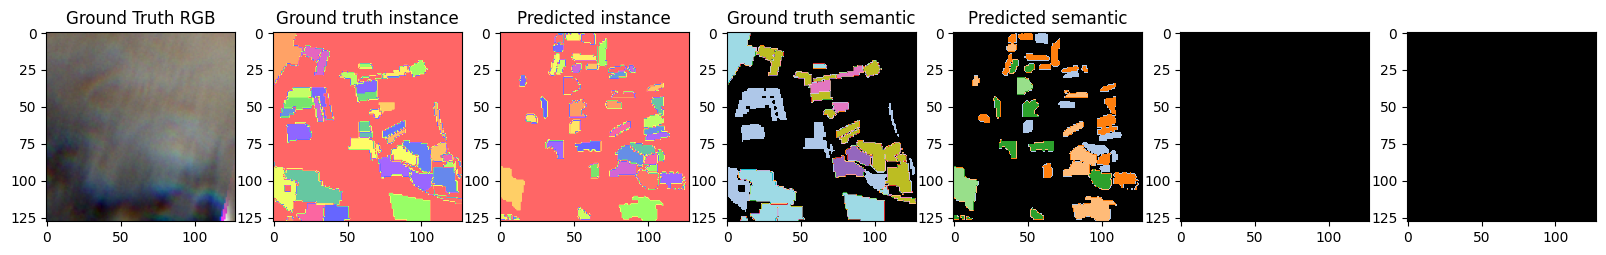

In [80]:
fold = 0
print("Testing best epoch . . .")
model.load_state_dict(
    torch.load(
        os.path.join(
            WEIGHT_FOLDER, f"Fold_{fold+1}","model.pth.tar"
        )
    )["state_dict"]
)
model.eval()

for i, batch in enumerate(test_dataloader):
    if i==0:
        if DEVICE is not None:
            batch = recursive_todevice(batch, DEVICE)
        (x, dates), y = batch
#         (x, dates) = x['S2'], dates['S2']
        y = y.long()
#         print(x.shape)
#         print(y.shape)

        with torch.no_grad():
            out = model(x, batch_positions=dates,
                    pseudo_nms=True,
                    heatmap_only=False)


        loss = criterion(out, y)


#         with torch.no_grad():
#             pred = out.argmax(dim=1)
#             print(pred.shape)
    else:
        break

import torchvision.transforms as T
from PIL import Image
import cv2

def get_rgb(x, batch_index=1, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im
# print(pred[1].shape) 
(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)


print(out.keys())
# print(label1.shape)
# print(out['pano_instance'][1].shape)
# print(len(out['pano_instance']))
# tensor1 = out['pano_instance'][1].cpu().numpy()
# # cv2.imwrite("tensor1.png",tensor1)
# # cv2.imwrite("label1.png",label1)

import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.colors import ListedColormap



bid =1
pano_instance = out['pano_instance'][bid].cpu().numpy()
pano_semantic = out['pano_semantic'][bid].cpu().numpy()

print(out['confidence'].shape)

print(pano_instance.shape)
print(pano_semantic.shape)

print(np.sum(pano_semantic, axis=0).shape)

print(instance_ids.shape)
print(pixel_semantic_annotation.shape)


cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k']+[def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors= cus_colors, name='agri', N=21)

fix, axes = plt.subplots(1,7, figsize=(20,20))
axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(instance_ids[bid].squeeze().cpu(), cmap='prism', alpha=.6)
axes[2].imshow(pano_instance, cmap='prism', alpha=.6)

axes[3].imshow(pixel_semantic_annotation[bid].squeeze().cpu(), cmap=cmap, vmin=0, vmax=20)
axes[4].imshow(pano_semantic[1],cmap=cmap, vmin=0, vmax=20 )
axes[5].imshow(pano_semantic[2],cmap=cmap, vmin=0, vmax=20 )
axes[6].imshow(np.mean(pano_semantic, axis=0),cmap=cmap, vmin=0, vmax=20 )
# axes[1].imshow(tensor1,cmap=cmap, vmin=0, vmax=20 )

axes[0].set_title('Ground Truth RGB')
axes[1].set_title('Ground truth instance')

axes[2].set_title('Predicted instance')
axes[3].set_title('Ground truth semantic')
axes[4].set_title('Predicted semantic')


In [73]:
cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]

/tmp/ipykernel_1124/1340348351.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


In [84]:
# def load_model(path, device, fold=1, mode='semantic'):
#     """Load pre-trained model"""
#     with open(os.path.join(path, 'conf.json')) as file:
#         config = json.loads(file.read())
#     config = Namespace(**config)
#     model = get_model(config, mode = mode).to(device)

#     sd = torch.load(
#         os.path.join(path, "Fold_{}".format(fold+1), "model.pth.tar"),
#         map_location=device
#         )
#     model.load_state_dict(sd['state_dict'])
#     return model

# def get_rgb(x,b=0,t_show=6):
#     """Gets an observation from a time series and normalises it for visualisation."""
#     im = x[b,t_show,[2,1,0]].cpu().numpy()
#     mx = im.max(axis=(1,2))
#     mi = im.min(axis=(1,2))   
#     im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
#     im = im.swapaxes(0,2).swapaxes(0,1)
#     im = np.clip(im, a_max=1, a_min=0)
#     return im


from matplotlib import patches
def plot_pano_predictions(pano_predictions, pano_gt, ax, cmap=cmap, batch_element=0, alpha=.5):
    pano_instances = pano_predictions['pano_instance'][batch_element].squeeze().cpu().numpy()
    pano_semantic_preds = pano_predictions['pano_semantic'][batch_element].argmax(dim=0).squeeze().cpu().numpy()
    grount_truth_semantic = y[batch_element,:,:,-1].cpu().numpy()

    for inst_id in np.unique(pano_instances):
        if inst_id==0:
            continue # ignore background
        mask = (pano_instances==inst_id)
        try:
            # Get polygon contour of the instance mask
            c,h= cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Get the ground truth semantic label of the segment
            u,cnt  = np.unique(grount_truth_semantic[mask], return_counts=True)
            cl = u if np.isscalar(u) else u[np.argmax(cnt)]
            if cl==19: # Not showing predictions for "Void" segments
                continue

            # Get the predicted semantic label of the segment
            cl = pano_semantic_preds[mask].mean()
            color = cmap.colors[int(cl)]
            for co in c[0::2]:
                poly = patches.Polygon(co[:,0,:], fill=True, alpha=alpha, linewidth=0, color=color)
                ax.add_patch(poly)
                poly = patches.Polygon(co[:,0,:], fill=False, alpha=.8, linewidth=4, color=color)
                ax.add_patch(poly)
        except ValueError as e:
            print( cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE))
            
            
def plot_pano_gt(pano_gt, ax, cmap=cmap, batch_element=0, alpha=.5, plot_void=True):
    ground_truth_instances = y[batch_element,:,:,1].cpu().numpy()
    grount_truth_semantic = y[batch_element,:,:,-1].cpu().numpy()

    for inst_id in np.unique(ground_truth_instances):
        if inst_id==0:
            continue  
        mask = (ground_truth_instances==inst_id)
        try:
            c,h= cv2.findContours(mask.astype(int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
            u,cnt  = np.unique(grount_truth_semantic[mask], return_counts=True)
            cl = u if np.isscalar(u) else u[np.argmax(cnt)]
            
            if cl==19 and not plot_void: # Not showing predictions for Void objects
                continue
            
            color = cmap.colors[int(cl)]
            for co in c[1::2]:
                poly = patches.Polygon(co[:,0,:], fill=True, alpha=alpha, linewidth=0, color=color)
                axes[b,1].add_patch(poly)
                poly = patches.Polygon(co[:,0,:], fill=False, alpha=.8, linewidth=4, color=color)
                axes[b,1].add_patch(poly)
        except ValueError as e:
            print(e)

In [85]:
batch = recursive_todevice(iterator.__next__(), device)
iterator =  test_dataloader.__iter__()
with torch.no_grad():
    (x, dates), y = batch
    predictions = model(x, batch_positions=dates)
#     sempred = utae(x, batch_positions=dates)
#     sempred = sempred.argmax(dim=1)

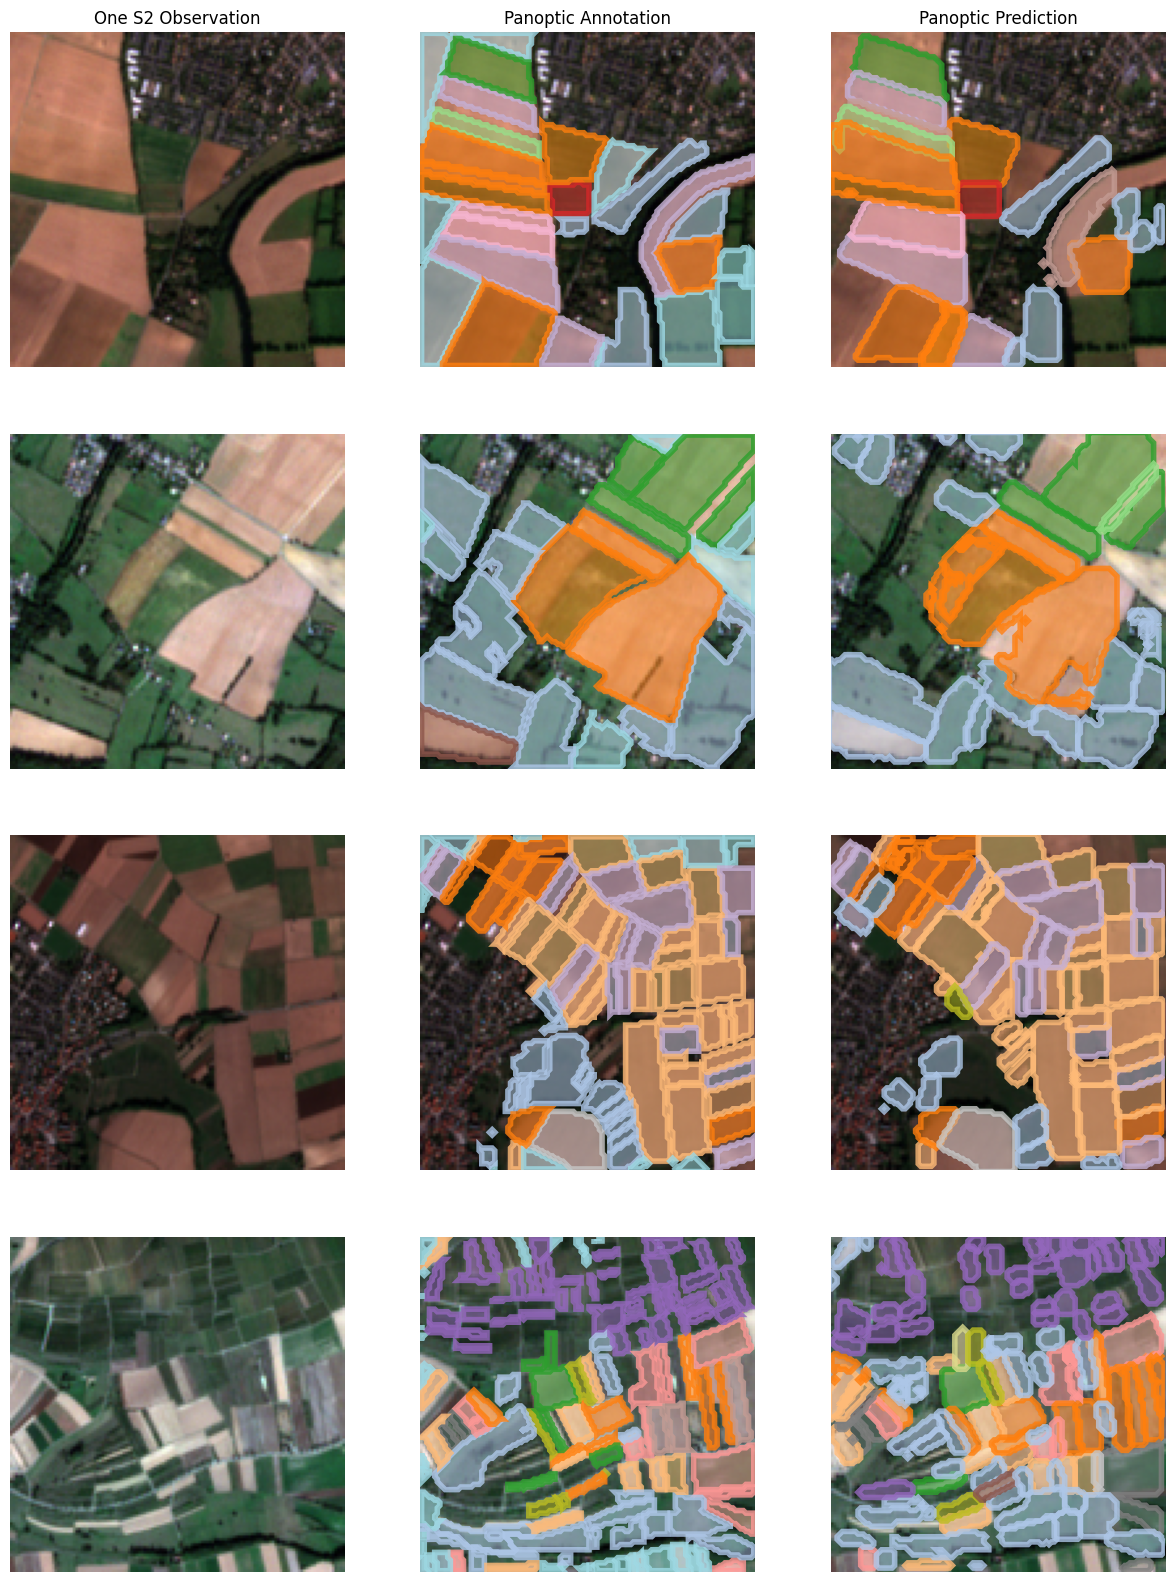

In [86]:
# Visualisation of the semantic and panoptic predictions
size =5

fig, axes = plt.subplots(BATCH_SIZE,3,figsize=(3*size, BATCH_SIZE*size))
t=2
alpha=.5

for b in range(BATCH_SIZE):
    # Plot S2 background
    im = get_rgb(x, batch_index=b, t_show=t)
    axes[b,0].imshow(im)
    axes[b,2].imshow(im)
    axes[b,1].imshow(im)
    
    ## Plot ground truth instances
    plot_pano_gt(pano_gt=y,
                 ax=axes[b,1],
                 cmap=cmap,
                 batch_element=b,
                 alpha=alpha,
                 plot_void=True)
    
    ## Plot predicted instances
    plot_pano_predictions(pano_predictions=predictions,
                          pano_gt=y,
                          ax=axes[b,2],
                          cmap=cmap,
                          batch_element=b,
                          alpha=alpha)
    
    # Plot Semantic Segmentation prediction
#     axes[b,3].matshow(sempred[b].cpu().numpy(),
#                       cmap=cmap,
#                       vmin=0,
#                       vmax=19)

    axes[b,0].axis('off')
    axes[b,1].axis('off')
    axes[b,2].axis('off')
#     axes[b,3].axis('off')
    
    axes[0,0].set_title('One S2 Observation')
    axes[0,1].set_title('Panoptic Annotation')
    axes[0,2].set_title('Panoptic Prediction')
#     axes[0,3].set_title('Semantic Prediction')

In [87]:
fig.savefig('UTAE_VIS.png')